<div>
     <center>
     <h1> Galaxy dynamics </h1>
     <br>
     by <a href="http://github.com/ComputoCienciasUniandes"> ComputoCienciasUniandes </a>
     <br>
     <a href = "https://github.com/jsbarbosa"> Juan Barbosa </a>
     </center>
</div>
<hr style="height:5px">

# Librerías

In [1]:
import numpy as np
from core import *
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Sistema
### El problema de $N$ cuerpos
Para tres o más cuerpos que interactúan entre sí gravitacionalmente, resulta imposible la predicción analítica de los movimientos de forma indiviual. Lo anterior supone una gran oportunidad para los métodos numéricos, en donde el problema estará restringido a la capacidad de cómputo disponible. En ese sentido para un sistema de $N$ cuerpos es necesario iterar $\frac{1}{2}N(N-1)$ veces para obtener la totalidad de fuerzas actuando sobre cada cuerpo.
$$ F_{i} = -\sum\limits_{j\neq i}^{N} \frac{Gm_im_j}{|\vec{r}_{ij}|^3}(\vec{r}_i - \vec{r}_j)$$

Lo anterior implica que los requerimientos computacionales aumentan rápidamente con el número de partículas $N$.

### $N \log N$ como solución
El algoritmo propuesto por Barnes y Hut en 1983 funciona acomodando todas las partículas en un árbol de cubos. El arbol recibe el nombre de *octree* el cual se arma de forma recursiva dividiendo el espacio en 8 ocho cubos, hasta que todas las partículas estén solas en una caja.

<img src = "http://www.pcl-users.org/file/n4019246/octree.gif">

Todas las cajas tienen un centro de masa, para aquellas que contienen una única partícula este corresponde con la posición de la partícula. Para los casos donde la caja está en una rama interna del arbol, el centro de masa corresponde con:
$$ \vec{r}_{cm} = \frac{1}{M}\sum_{i = 0}^{N} m_i\vec{r}_i \qquad \text{donde } M \text{ corresponde a la masa total contenida en la caja}$$

 <table style="width:100%">
  <tr>
    <th><img src="boxes_points.gif" style="width:320px;height:240px;"></th>
    <th><img src="boxes.gif" style="width:320px;height:240px;"></th>
    <th><img src="boxes_child_only.gif" style="width:320px;height:240px;"></th>
  </tr>
</table> 

La fuerza sobre una partícula se calcula usando la ley de gravitación universal, sin embargo es posible que la interacción sea partícula-partícula o partícula-caja, donde la última será con la totalidad de la masa contenida en la caja y el centro de masa de la misma. Para determinar qué tipo de interacción tiene lugar se realiza un cociente $(l/d)$ entre el tamaño de la caja $(l)$ y la distancia entre la partícula y el centro de masa de la caja $(d)$. Siempre que el cociente sea menor a una constante $\theta$ --que da cuenta de la exactitud del algoritmo--, se tiene la interacción partícula-caja, en caso contrario se recurre a realizar el mismo cálculo con el siguiente nivel del arbol.

<hr style="height:2px">
# Integrador
La ecuación diferencial resultante se resuelve numéricamente usando Leapfrog, para el cual las posiciones y velocidades se actualizan de manera asincrónica.
$$ v_{i+1/2} = v_{i} + a_{i}\frac{\Delta t}{2}$$
$$ x_{i+1} = x_{i} + v_{i+1/2}\Delta t $$
$$ v_{i+1} = v_{i+1/2} + a_{i+1}\frac{\Delta t}{2} $$

<hr style="height:2px">
# Condiciones iniciales
### Posiciones
Para construir la posición se usa el método `galaxy(N, size, arms)` el cual recibe el número de partículas $(N)$ que compondrán la galaxia, el diámetro $(size)$ de la misma en kpc y el número de brazos $(arms)$ que tendrá la espiral.

In [2]:
G = 44.97
N = 1000
M = 2.0*1000/N
diameter = 20
epsilon = diameter*0.001
arms = 2

In [3]:
def galaxy(N_, size, arms = 5):
    """
    Construye una espiral dos dimensional con arms cantidad de brazos, usando N/arms puntos en cada uno.
    Normaliza el tamano usando size.
    """
    a = 0.4
    b = 0.7
    N = int(N_/(arms+1))
    t = np.random.randn(N) + 0.5
#    t = 5*(np.random.random(N) - 0.5)
    excess = np.where(t>2)[0]
    t[excess] = np.random.rand(len(excess))/1000
    x = np.array([0])
    y = np.array([0])
    
    for i in range(arms):   
        xv = a*np.exp(b*t)*np.cos(t+2*i*np.pi/arms)
        yv = a*np.exp(b*t)*np.sin(t+2*i*np.pi/arms)
        r = np.sqrt(xv**2 + yv**2)
        u = 0.1*abs(np.log(r))#0.05*np.exp(r)/r
        u = 0.04*np.exp(r)
        xt = xv + np.random.normal(0, u, N)
        yt = yv + np.random.normal(0, u, N)
            
        x = np.hstack((x, xt))
        y = np.hstack((y, yt))

    r = np.random.random(N)*0.15*arms
    theta = np.random.random(N)*2*np.pi
    xt = r*np.cos(theta)
    yt = r*np.sin(theta)
    x = np.hstack((x, xt))
    y = np.hstack((y, yt))
    must_have = N_ - x.shape[0] + 1
    if must_have != 0:
        xt = np.random.random(must_have)*0.1
        yt = np.random.random(must_have)*0.1
        x = np.hstack((x, xt))
        y = np.hstack((y, yt))
    rank = max(x) - min(x)
    return x[1:]*size/rank, y[1:]*size/rank

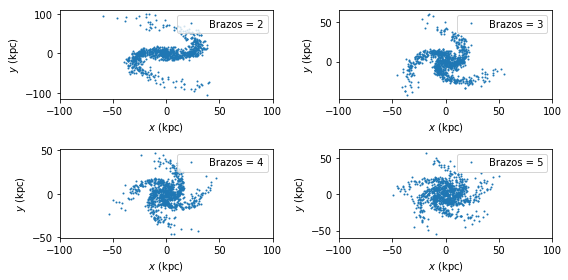

In [4]:
N = 1000
fig, axes = plt.subplots(2, 2, figsize=(8, 4))
axes = axes.reshape(4)
for i in range(4):
    x, y = galaxy(N, 100, arms = i+2)    
    axes[i].plot(x, y, "o", ms=1, label = "Brazos = %d"%(i+2))
    axes[i].set_xlabel("$x$ (kpc)")
    axes[i].set_ylabel("$y$ (kpc)")
    axes[i].legend(loc = 1)
    axes[i].set_xlim(-100, 100)
    
plt.tight_layout()
plt.show()

### Velocidades
Para calcular las velocidades se aproximan las órbitas de las estrellas a círculos, lo anterior permite expresar la velocidad en términos de la aceleración.
$$ v = \sqrt{ar} = \sqrt{\frac{GM}{r}} \qquad \text{donde } M \text{ corresponde a toda la masa que se encuentra a un radio menor a } r$$

In [5]:
N_half = int(0.5*N)
theta = np.pi/4
rotx, roty, rotz = rotation_matrixes(theta)
x1, y1 = galaxy(N_half, diameter, arms=arms)
x2, y2 = galaxy(N_half, diameter, arms=arms)
z1 = np.random.randn(N_half)*0.01*diameter
z2 = np.random.randn(N_half)*0.01*diameter

galaxy1 = np.zeros((3, N_half))
galaxy2 = np.zeros((3, N_half))
galaxy1[:] = x1, y1, z1
galaxy2[:] = x2, y2, z2
       
center1 = np.mean(galaxy1, axis = 1)
distances1 = np.array([galaxy1[i] - center1[i] for i in range(3)])
speeds1 = speeds_generator(distances1, G, M)

center2 = np.mean(galaxy2, axis = 1)
distances2 = np.array([galaxy2[i] - center2[i] for i in range(3)])
speeds2 = speeds_generator(distances2, G, M)

galaxy2 = np.dot(rotx, galaxy2)
speeds2 = np.dot(rotx, speeds2)       
       
system = np.zeros((3, N))
system[:, :N_half] = galaxy1 - diameter
system[:, N_half:] = galaxy2 + diameter 
speeds = np.zeros_like(system)

speeds[:, :N_half] = speeds1
speeds[:, N_half:] = speeds2

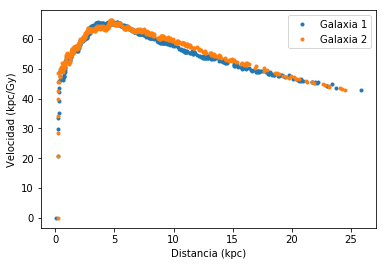

In [6]:
galaxy_speeds = [speeds1, speeds2]
distances = [distances1, distances2]
labels = ["Galaxia 1", "Galaxia 2"]
for i in range(2):
    sp = np.sqrt(np.sum(galaxy_speeds[i]**2, axis = 0))
    d = np.sqrt(np.sum(distances[i]**2, axis = 0))
    plt.plot(d, sp, "o", ms = 3, label = labels[i])
    galaxy_speeds[i] = sp
    distances[i] = d
    
plt.xlabel("Distancia (kpc)")
plt.ylabel("Velocidad (kpc/Gy)")
plt.legend()
plt.show()

Las condiciones iniciales se resumen en la distribución de posiciones y velocidades.

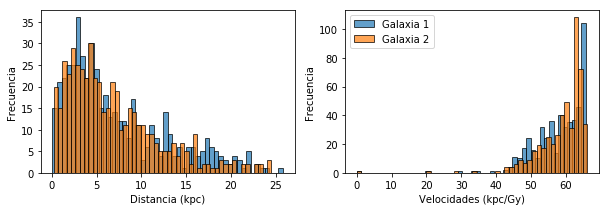

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for i in range(2):
    axes[0].hist(distances[i], bins = 50, lw=1, edgecolor="k", alpha = 0.7)
    axes[1].hist(galaxy_speeds[i], bins = 50, lw=1, edgecolor="k", alpha = 0.7, label=labels[i])
    axes[i].set_ylabel("Frecuencia")
axes[0].set_xlabel("Distancia (kpc)")
axes[1].set_xlabel("Velocidades (kpc/Gy)")
axes[1].legend()
plt.show()

<hr style="height:2px">
# Simulación
La función `solver(positions, speeds, N, t, dt , G, filename='Data/', tolerance = 1, mass = 1, epsilon = 0.1)` dentro de `core` resuelve las ecuaciones diferenciales asociadas al sistema, además de reconstruir el arbol con cada iteración. Devuelve el número de instantes de tiempo calculados, y graba en la carpeta `filename` las posiciones y velocidades en cada instante.

In [10]:
%matplotlib
sim = simulation(M, G, epsilon, pos = system, speeds = speeds)
sim.start(0, 0.15, 0.005)

Using matplotlib backend: Qt5Agg


/home/juan/Documents/astro-hut/c_build/core.py:27: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  elif pos != None and speeds != None:


In [9]:
data = read_output()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
N_half = int(N/2)
plot1 = ax.plot([], [], [], "o", ms=0.5, c="g", alpha = 0.5)[0]
plot2 = ax.plot([],[],[], "o", ms=0.5, c="b", alpha = 0.5)[0]
ax.set_xlabel("$x$ kpc")
ax.set_ylabel("$y$ kpc")
ax.set_zlabel("$z$ kpc")

def update(i):
    temp = data[i]
    plot1.set_data(temp[:N_half,0], temp[:N_half,1])
    plot1.set_3d_properties(temp[:N_half, 2])
    plot2.set_data(temp[N_half:,0], temp[N_half:,1])
    plot2.set_3d_properties(temp[N_half:, 2])

min_value, max_value = -50, 50
ax.set_xlim(min_value, max_value)
ax.set_ylim(min_value, max_value)
ax.set_zlim(min_value, max_value)
fig.tight_layout()
ani = FuncAnimation(fig, update, frames=len(data), interval=10)
#ani.save("animate.gif", writer='imagemagick', dpi=72)
plt.show()